# Import libraries

In [1]:
import os
import pathlib
import shutil
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the dataset for loading

## Helper functions

In [2]:
def create_label_dir(df, dir='../gdsc-ai-challenge/train'):
    """Use Dataframe contains labels for each image and path to the directory

    contains the unlabeled dataset to rebuild directory into labeled subdirectories.

    Returns all the label and number of classes in the dataset.

    Keyword arguments:

    df -- The Dataframe contains images' names and labels.

    dir -- Path to the main directory (default to ../gdsc-ai-challenge/train)
    """
    class_names = np.sort(df['label'].unique())
    number_of_classes = len(class_names)

    if not os.path.exists(dir):
        return class_names, number_of_classes

    for class_name in class_names:
        subdir = pathlib.Path(os.path.join(dir, class_name))
        if subdir.exists():
            continue
        else:
            subdir.mkdir()
    
    return class_names, number_of_classes

def sort_data(df, dir='../gdsc-ai-challenge/train'):
    """Use Dataframe to move each unlabeled image to the correct label's subdirectory.

    df -- The Dataframe contains images' names and labels.

    dir -- Path to the main directory (default to ../gdsc-ai-challenge/train) 
    """
    if not os.path.exists(dir):
        return
    
    unlabeled_dir = os.path.join(dir, 'train')

    for image_dir in [str(img) for img in list(pathlib.Path(unlabeled_dir).glob('*.png'))]:
        id = int(image_dir.removeprefix(unlabeled_dir).removesuffix('.png'))
        label = df['label'][id - 1]
        dest_path = os.path.join(dir, label, str(id) + '.png')
        shutil.move(image_dir, dest_path)

## Prepare the dataset

In [3]:
label_df = pd.read_csv('../gdsc-ai-challenge/trainLabels.csv')

class_names, number_of_classes = create_label_dir(label_df)
sort_data(label_df)

# Data preprocessing and augmentation

## Helper functions

In [4]:
def split_dataset(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
    """Split the dataset into three subsets: train, validation (dev) and test set.

    Returns three tuples, containing each subset with its size.

    Keyword arguments:

    ds -- tf.data.Dataset object

    ds_size -- size of the dataset

    train_split -- percentage to split into train set (default to 0.8)

    val_split -- percentage to split into validation set (default to 0.1)

    test_split -- percentage to split into test set (default to 0.1)
    """
    assert (train_split + test_split + val_split) == 1
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return (train_ds, train_size), (val_ds, val_size), (test_ds, ds_size - val_size - train_size)

def configure(ds, ds_size, batch_size=32, shuffle=True, augment=False):
    """Configure the given dataset for better performance (by caching, prefetching and then batching the dataset)

    and perform preprocessing to the images in the given dataset.

    Returns the optimized dataset.

    Keyword arguments:

    ds -- tf.data.Dataset object

    ds_size -- size of the dataset

    batch_size -- size of each batch (default to 32)

    shuffle -- whether to shuffle the dataset (default to True)

    augment -- whether to perform data augmentation to the dataset (default to False)
    """

    AUTOTUNE = tf.data.AUTOTUNE
    rescale = keras.layers.Rescaling(1.0/255)
    data_augmentation = keras.Sequential([
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(0.05, fill_mode='nearest')
    ])

    ds = ds.map(lambda x, y: (rescale(x), y),
                num_parallel_calls=AUTOTUNE)

    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=int(ds_size * 0.6))
    
    ds = ds.batch(batch_size)

    if augment:
        with tf.device('/cpu:0'):
            #only perform data augmentation on train set
            ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                                    num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

## Load the dataset using *image_dataset_from_directory()*

In [5]:
ds = tf.keras.utils.image_dataset_from_directory(
    '../gdsc-ai-challenge/train',
    color_mode='grayscale',
    batch_size=None,
    image_size=(32,32),
    seed=42
)

ds_size = ds.cardinality().numpy()

Found 50000 files belonging to 10 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-15 01:58:18.787661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-15 01:58:18.787773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Split the dataset and Preprocess the dataset

In [6]:
(train_ds, train_size), (val_ds, val_size), (test_ds, test_size) = split_dataset(ds, ds_size, train_split=0.7, val_split=0.2, test_split=0.1)

train_ds = configure(train_ds, train_size, augment=True)
val_ds = configure(val_ds, val_size)
test_ds = configure(test_ds, test_size)

# Build a model

In [7]:
model = keras.models.Sequential([
    keras.layers.Input((32,32,1)),
    keras.layers.Conv2D(32, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-4),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-4),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(64, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-4),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-4),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(128, (1,1), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-4),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (1,1), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-4),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='elu',
                       kernel_regularizer=regularizers.l2(1e-3),
                       activity_regularizer=regularizers.l2(1e-4)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='elu',
                       kernel_regularizer=regularizers.l2(1e-3),
                       activity_regularizer=regularizers.l2(1e-4)),
    keras.layers.Dense(number_of_classes, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003),
                                              loss='sparse_categorical_crossentropy',
                                              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                      

# Training session

## Design a callback to stop training

In [9]:
class stopCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}) :
        if (logs.get('accuracy') >= 0.999 and 
            logs.get('val_accuracy') >= 0.999) :
            print('\nReached 99.9% accuracy so stopping training')
            self.model.stop_training = True

callback = stopCallback()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='../Model/aiseries/version1.hdf5',
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

In [10]:
history = model.fit(train_ds, 
                    epochs=100, 
                    callbacks=[callback, model_checkpoint_callback], 
                    validation_data=val_ds)

Epoch 1/100


2022-03-15 01:58:19.371598: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-15 01:58:20.024941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1094/1094 [==============================] - ETA: 0s - loss: 6.1728 - accuracy: 0.3012

2022-03-15 01:59:26.761310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1094/1094 [==============================] - 77s 69ms/step - loss: 6.1728 - accuracy: 0.3012 - val_loss: 5.3009 - val_accuracy: 0.3319
Epoch 2/100
1094/1094 [==============================] - 89s 81ms/step - loss: 4.4326 - accuracy: 0.4025 - val_loss: 4.1635 - val_accuracy: 0.4581
Epoch 3/100
1094/1094 [==============================] - 93s 85ms/step - loss: 3.6374 - accuracy: 0.4598 - val_loss: 3.8115 - val_accuracy: 0.4189
Epoch 4/100
1094/1094 [==============================] - 92s 84ms/step - loss: 3.1111 - accuracy: 0.4958 - val_loss: 3.2188 - val_accuracy: 0.4880
Epoch 5/100
1094/1094 [==============================] - 92s 84ms/step - loss: 2.7296 - accuracy: 0.5229 - val_loss: 2.8234 - val_accuracy: 0.5343
Epoch 6/100
1094/1094 [==============================] - 93s 85ms/step - loss: 2.4583 - accuracy: 0.5493 - val_loss: 2.4807 - val_accuracy: 0.5808
Epoch 7/100
1094/1094 [==============================] - 92s 84ms/step - loss: 2.2427 - accuracy: 0.5680 - val_loss: 2.3745 - val_

## Evaluation session

## Evaluate on the test set

In [11]:
model.evaluate(test_ds)

157/157 [==============================] - 9s 39ms/step - loss: 1.0555 - accuracy: 0.7280


[1.0555343627929688, 0.7280000448226929]

## Evaluate based on training session

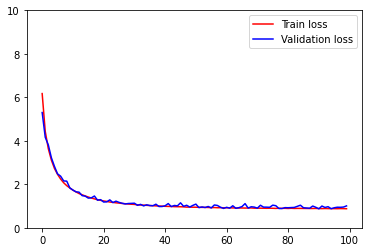

In [12]:
plt.plot(history.history['loss'], color='red', label='Train loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation loss')
plt.ylim((0, 10))
plt.legend()
plt.show()